In [1]:
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
thrb = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"
actb = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF"

In [2]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids

protein = pr39

enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.3, "I": 0.3, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)



In [3]:
from disassembly.simulate_proteolysis import ProteolysisSimulator

results = {}
test_names = ["simple", "medium", "complex", "random"]
iterations = 2
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

# Simulating peptidomes
ps = ProteolysisSimulator()
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = ps.simulate_proteolysis(
            protein,
            enzymes,
            n_start=3,
            n_generate=500,
            endo_or_exo_probability=[0.9, 0.1],
            length_params="vivo"
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph


Running simple 0
 0 / 500 (1)

 65 / 500 (68)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:229: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values())


 499 / 500 (525)
25 unique peptides. 503 total
Running simple 1
 499 / 500 (604)
23 unique peptides. 503 total
Running medium 0
 499 / 500 (485)
104 unique peptides. 505 total
Running medium 1
 499 / 500 (528)
106 unique peptides. 504 total
Running complex 0
 499 / 500 (592)
121 unique peptides. 503 total
Running complex 1
 498 / 500 (606)
121 unique peptides. 503 total
Running random 0
 498 / 500 (479)
432 unique peptides. 503 total
Running random 1
 498 / 500 (505)
439 unique peptides. 503 total


0.6968803223528435

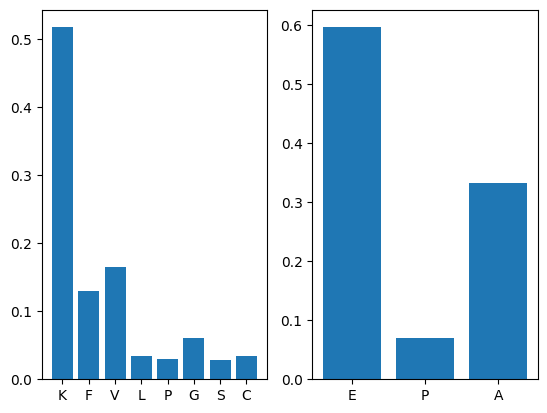

In [5]:
from disassembly.cut_site import get_p1
import matplotlib.pyplot as plt

p1_endo, p1_exo,  n_endo, n_exo = get_p1(simulated_graphs["simple"][0], 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

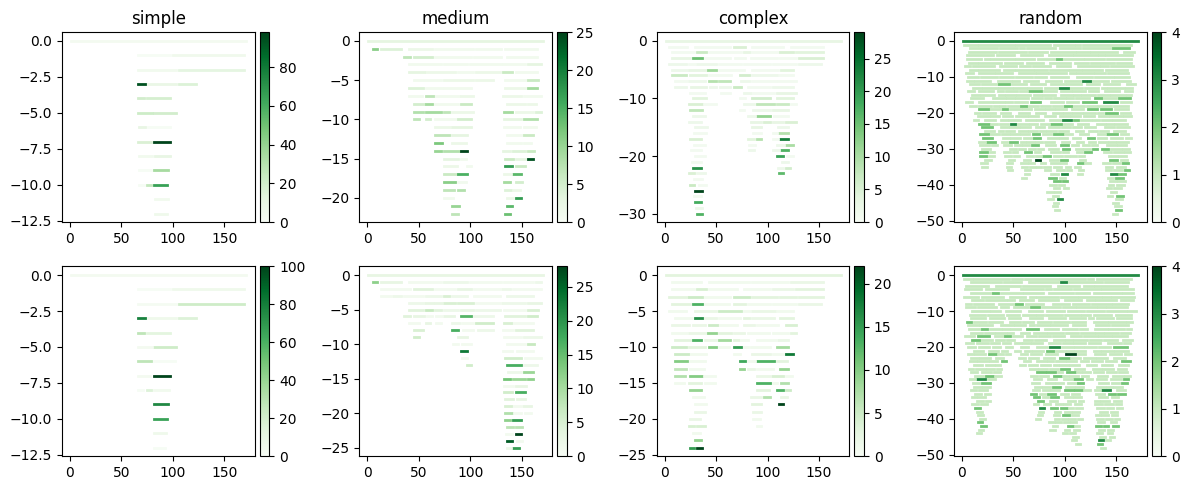

In [6]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()

# Regex

In [7]:
from disassembly.simulate_proteolysis_regex import Enzyme
trypsin_regex = Enzyme("trypsin", {"..[RK](?!P).." : 1})
random_regex = Enzyme("random", {"......": 1})
chymotrp_regex = Enzyme("chymotrypsin", {"..[FYW](?=[^P]).." : 1})

from disassembly.simulate_proteolysis_regex import ProteolysisSimulator

results = {}
test_names = ["trypsin", "random", "chymotrypsin"] #["simple", "medium", "complex", "random"]
iterations = 2
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

# Simulating peptidomes
ps = ProteolysisSimulator()
for test_name, enzymes in zip(test_names, [trypsin_regex, random_regex, chymotrp_regex]):
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = ps.simulate_proteolysis(
            protein,
            enzymes,
            n_start=3,
            n_generate=200,
            endo_or_exo_probability=[0.9, 0.1],
            length_params="vivo",
            noise=1e-10
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph


Running trypsin 0
 42 / 200 (44)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis_regex.py:28: RuntimeWarning: divide by zero encountered in divide
  cleavage_probabilities = cleavage_probabilities / sum(cleavage_probabilities)
/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis_regex.py:28: RuntimeWarning: invalid value encountered in divide
  cleavage_probabilities = cleavage_probabilities / sum(cleavage_probabilities)


 198 / 200 (196)
57 unique peptides. 203 total
Running trypsin 1
 199 / 200 (179)
61 unique peptides. 204 total
Running random 0
 199 / 200 (251)
119 unique peptides. 203 total
Running random 1
 199 / 200 (247)
129 unique peptides. 204 total
Running chymotrypsin 0
 199 / 200 (208)
26 unique peptides. 203 total
Running chymotrypsin 1
 198 / 200 (200)
37 unique peptides. 203 total


0.7213400697702393

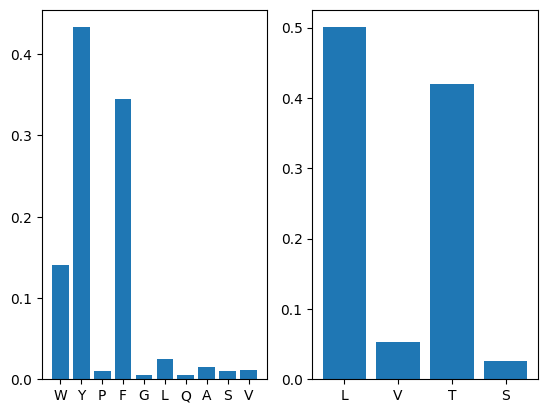

In [10]:
from disassembly.cut_site import get_p1
import matplotlib.pyplot as plt

p1_endo, p1_exo,  n_endo, n_exo = get_p1(simulated_graphs["chymotrypsin"][0], 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

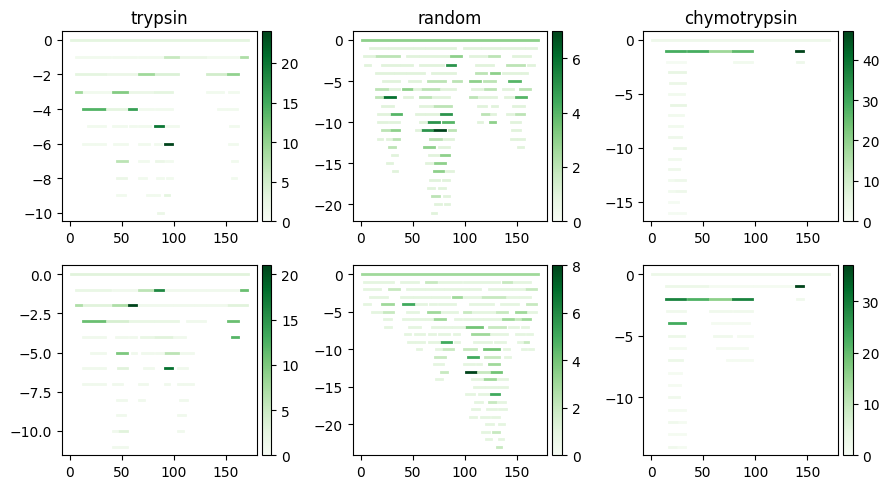

In [9]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()